This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# ESTEEM3 workshop

<div class="alert alert-info">

Note

This tutorial was given at the ESTEEM3 2022 workshop entitled [*Electron
diffraction for solving engineering problems*](https://www.esteem3.eu/news?backRef=86&news=Electron_diffraction_for_solving_engineering_problems_Department_of_Physics_NTNU),
held at NTNU in Trondheim, Norway in June 2022.

The tutorial has been updated to work with the current release of kikuchipy and
to fit our documentation format. The dataset is available from Zenodo at
<cite data-cite="aanes2019electron">Ånes et al. (2019)</cite>, and is scan number
7 (17 dB) out of the series of 10 (22 dB) scans taken with increasing gain
(0-22 dB).

</div>

In this tutorial we will inspect a small (100 MB) EBSD data of polycrystalline
recrystallized nickel by (Hough and dictionary) indexing and inspect the results
using geometrical EBSD simulations.

Steps:

1. Data overview (virtual backscatter electron imaging)
2. Enhance Kikuchi pattern (background correction)
3. Data overview ("feature maps")
4. Hough indexing
5. Verification of results (geometrical simulations)
6. Dictionary indexing
7. Orientation refinement
8. Summary

Tools:

* kikuchipy: https://kikuchipy.org
* HyperSpy: https://hyperspy.org
* PyEBSDIndex: https://pyebsdindex.readthedocs.io
* orix: https://orix.readthedocs.io
* diffsims: https://diffsims.readthedocs.io
* EMsoft (indirectly): https://github.com/EMsoft-org/EMsoft

Import libraries (replace `inline` with `qt5` plotting backend for interactive
plots in separate windows)

In [1]:
%matplotlib inline

import os

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, symmetry
from orix import io, plot, sampling
from orix.vector import Vector3d
from pyebsdindex import ebsd_index, pcopt


plt.rcParams.update({"figure.facecolor": "w", "font.size": 15, "figure.dpi": 75})

Load data

In [2]:
dir_data = "../../../kikuchipy_test/esteem"
s = kp.load(os.path.join(dir_data, "ebsd_data/Pattern.dat"))

In [3]:
s

<EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

Plot a pattern from a particular grain to show improvement in signal-to-noise ratio

In [4]:
s.axes_manager.indices = (156, 80)

Plot data

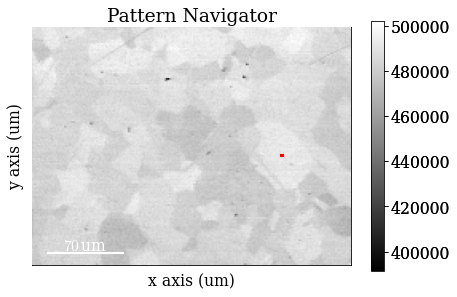

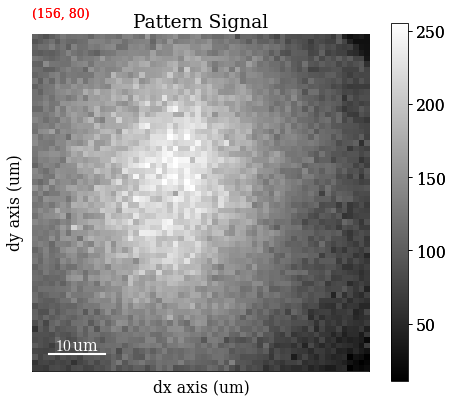

In [5]:
s.plot()

## Data overview (virtual backscatter electron [VBSE] imaging)

Mean intensity in each pattern

In [6]:
s_mean = s.mean(axis=(2, 3))
s_mean

<BaseSignal, title: Pattern, dimensions: (200, 149|)>

Save map

In [7]:
# plt.imsave(os.path.join(dir_data, "maps_mean.png"), s_mean.data, cmap="gray")

Set up VBSE generator

In [8]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)
vbse_gen

VirtualBSEGenerator for <EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

Plot VBSE grid

<EBSD, title: Pattern, dimensions: (|60, 60)>

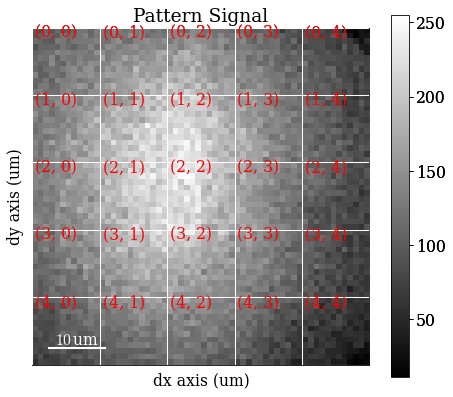

In [9]:
vbse_gen.plot_grid()

Specify RGB colour channels

In [10]:
r = (2, 1)
b = (2, 2)
g = (2, 3)

Plot coloured grid tiles

<EBSD, title: Pattern, dimensions: (|60, 60)>

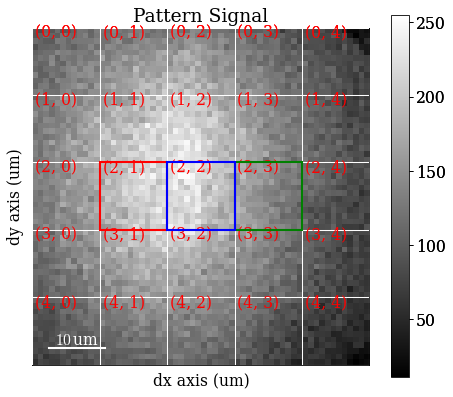

In [11]:
vbse_gen.plot_grid(rgb_channels=[r, g, b])

Get VBSE RGB image

In [12]:
vbse_rgb = vbse_gen.get_rgb_image(r, g, b)

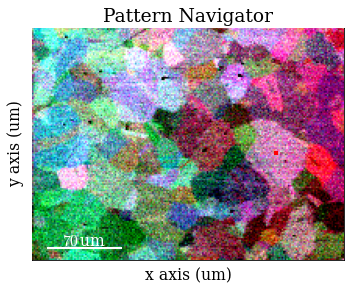

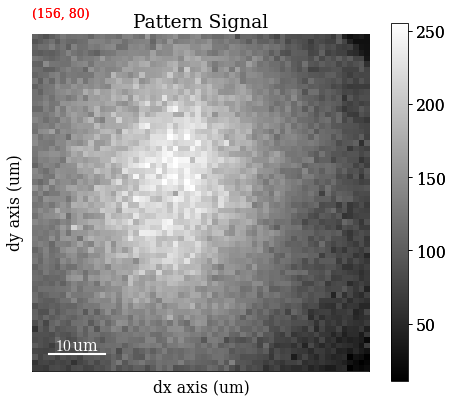

In [13]:
s.plot(vbse_rgb)

Save RGB image

In [14]:
# vbse_rgb.save(os.path.join(dir_data, "maps_vbse_rgb.png"))

## Enhance Kikuchi pattern (background correction)

Remove static (constant) background

In [15]:
s.remove_static_background()

[########################################] | 100% Completed | 711.30 ms


Inspect statically corrected patterns

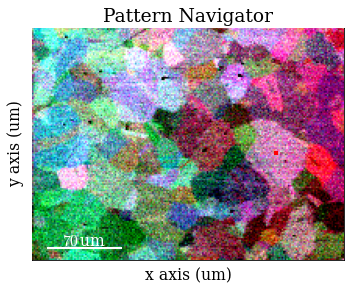

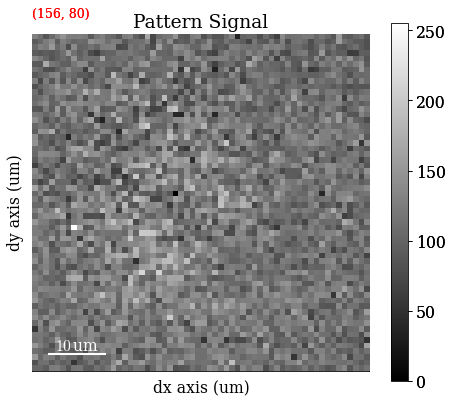

In [16]:
s.plot(vbse_rgb)

Remove dynamic (per pattern) background

In [17]:
s.remove_dynamic_background()

[########################################] | 100% Completed | 3.13 ss


Inspect dynamically corrected patterns

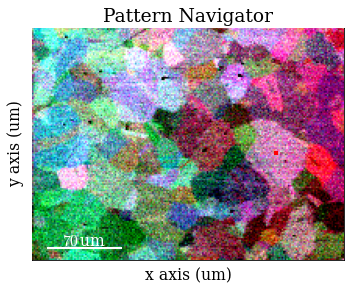

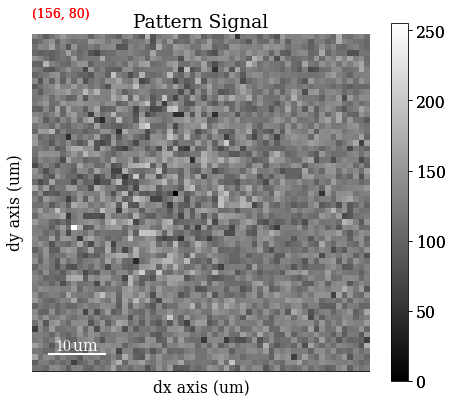

In [18]:
s.plot(vbse_rgb)

Average each patterns with the four nearest neighbours

In [19]:
s.average_neighbour_patterns()

[########################################] | 100% Completed | 1.02 sms


Inspect average patterns

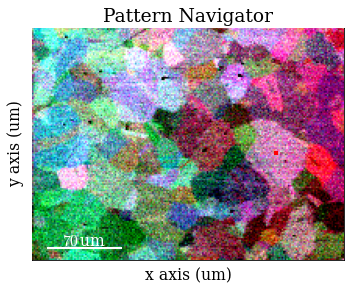

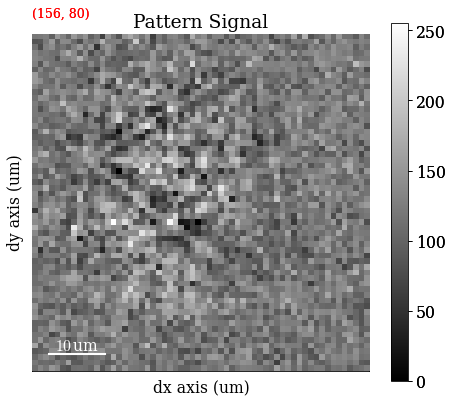

In [20]:
s.plot(vbse_rgb)

Save corrected patterns

In [21]:
# s.save(os.path.join(dir_data, "patterns_sda.h5"))

## Data overview ("feature maps")

Get image quality $Q$ map (not image quality IQ from Hough indexing!)

In [22]:
iq = s.get_image_quality()

[########################################] | 100% Completed | 1.62 ss


Navigate patterns in $Q$ map

In [23]:
s_iq = hs.signals.Signal2D(iq)

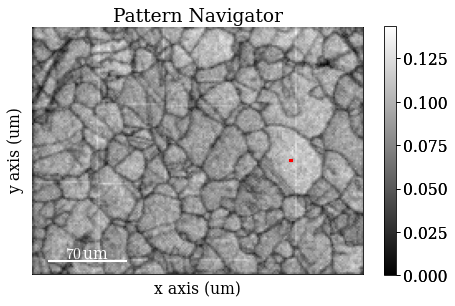

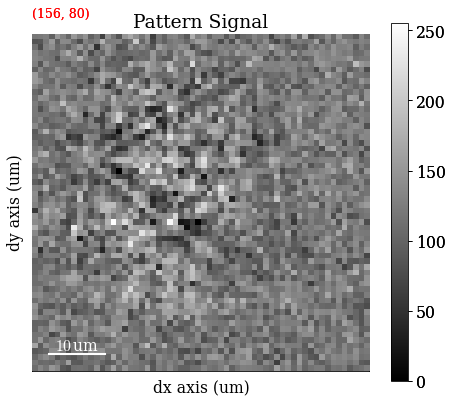

In [24]:
s.plot(s_iq)

Save $Q$ map to file

In [25]:
# plt.imsave(os.path.join(dir_data, "maps_iq.png"), s_iq.data, cmap="gray")

Get average neighbour dot product map (ADP)

In [26]:
adp = s.get_average_neighbour_dot_product_map()

[########################################] | 100% Completed | 6.77 ss


Navigate patterns in the ADP map

In [27]:
s_adp = hs.signals.Signal2D(adp)

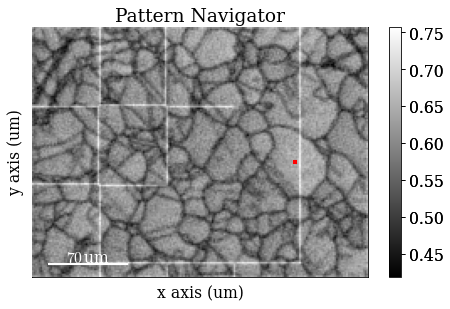

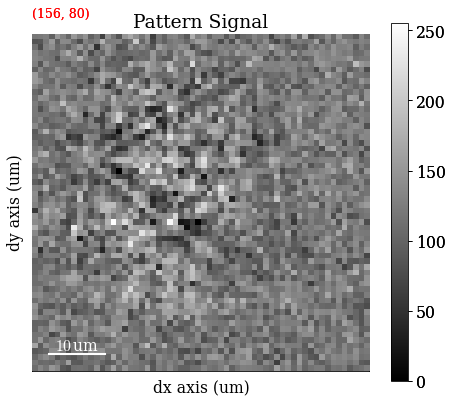

In [28]:
s.plot(s_adp)

Save ADP map to file

In [29]:
# plt.imsave(os.path.join(dir_data, "maps_adp.png"), s_adp.data, cmap="gray")

## Hough indexing (of calibration patterns)

Orientation of detector with respect to the sample:
* Known:
    * Sample tilt (about microscope X)
    * Camera tilt (about microscope X)
* Unknown:
    * Projection/pattern centre (PCx, PCy, PCz): Shortest distance from source point to detector

Load calibration patterns to get a mean PC for the data

In [30]:
s_cal = kp.load(os.path.join(dir_data, "ebsd_data/Setting.txt"))

In [31]:
s_cal

<EBSD, title: Calibration patterns, dimensions: (9|480, 480)>

In [32]:
s_cal.remove_static_background()
s_cal.remove_dynamic_background()

[########################################] | 100% Completed | 102.34 ms
[########################################] | 100% Completed | 102.69 ms


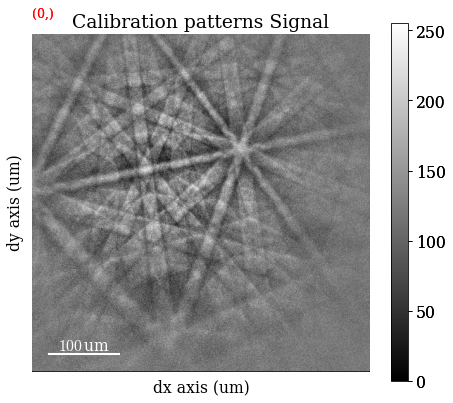

In [33]:
s_cal.plot(navigator="none")

Generate an indexer instance used to optimize the PC and to perform Hough indexing

In [34]:
sig_shape_cal = s_cal.axes_manager.signal_shape[::-1]
indexer_cal = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="KIKUCHIPY",
    sampleTilt=70,
    camElev=0,
    patDim=sig_shape_cal,
)

Given an initial guess of the PC and optimize for the first calibration pattern,
looking for convergence by updating `pc0` manually with the printed PC a couple
of times (the first run of `optimize()` takes longer since PyEBSDIndex has to
compile some code before running; consecutive runs are much quicker)

In [35]:
pc0 = [0.42, 0.21, 0.50]
pc = pcopt.optimize(s_cal.inav[0].data, indexer=indexer_cal, PC0=pc0)
print(pc)

[0.41590316 0.22707469 0.49999329]


Optimize for all calibration patterns

In [36]:
pc_all = np.zeros((9, 3))
for i in range(len(s_cal)):
    pc_all[i] = pcopt.optimize(s_cal.inav[i].data, indexer=indexer_cal, PC0=pc)

# Replace the above with the following after PyEBSDIndex > 0.1.0 is released
# pc_all = pcopt.optimize(s_cal.data, indexer_cal, pc, batch=True)

print(pc_all)

[[0.41583327 0.22709854 0.49995917]
 [0.41895273 0.22068711 0.5008015 ]
 [0.41887225 0.23007463 0.50296406]
 [0.41443618 0.22653622 0.50377738]
 [0.41593701 0.21124754 0.49446797]
 [0.42428707 0.23231358 0.50862284]
 [0.40896221 0.23179667 0.50335492]
 [0.40826038 0.23371639 0.50247888]
 [0.42064116 0.22100869 0.50032051]]


Calculate the mean PC

In [37]:
pc_mean = pc_all.mean(axis=0)
pc_mean

array([0.41624247, 0.22605326, 0.5018608 ])

Index the calibration patterns

Radon Time: 0.036838366999290884
Convolution Time: 0.0034607060078997165
Peak ID Time: 0.0017940160178113729
Band Label Time: 0.04321571398759261
Total Band Find Time: 0.08534417601185851


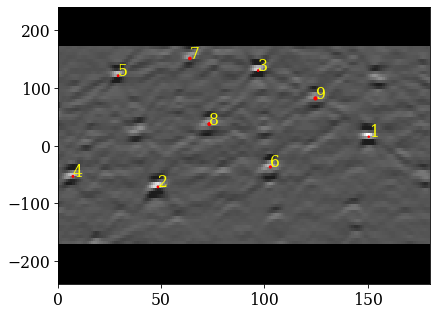

Band Vote Time:  0.028925258986419067


In [38]:
hi_res = indexer_cal.index_pats(s_cal.data, PC=pc_mean, verbose=2)[0]

Plot the returned orientations in the inverse pole figure (IPF), showing the
crystal direction $[uvw]$ parallel to the out-of-plane direction (Z)

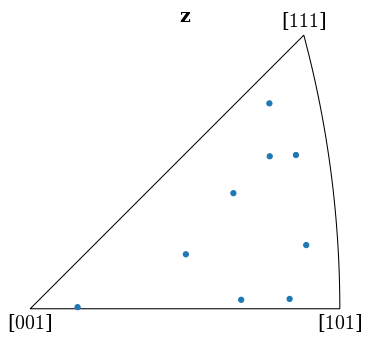

In [39]:
g = Orientation(hi_res[-1]["quat"], symmetry.Oh)
g.scatter("ipf")

We can determine whether the indexed orientations are correct by projecting
geometrical simulations (bands and zone axes) onto the patterns

## Geometrical simulations

Load a phase description from a CIF file

In [40]:
phase = Phase.from_cif(os.path.join(dir_data, "ni.cif"))

In [41]:
phase

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

In [42]:
phase.structure

[Ni   0.000000 0.000000 0.000000 1.0000,
 Ni   0.000000 0.500000 0.500000 1.0000,
 Ni   0.500000 0.000000 0.500000 1.0000,
 Ni   0.500000 0.500000 0.000000 1.0000]

In [43]:
phase.structure.lattice

Lattice(a=3.52387, b=3.52387, c=3.52387, alpha=90, beta=90, gamma=90)

Generate reflectors and filter the list on on minimum structure factor

In [44]:
ref = ReciprocalLatticeVector.from_min_dspacing(phase, 1)

ref.calculate_structure_factor()

f_real = abs(ref.structure_factor)
ref = ref[f_real > 0.5 * f_real.max()]

ref.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.035    11.8     140.0     100.0      8   
 2 0 0    1.762    10.4     108.2      77.3      6   
 2 2 0    1.246     7.4     55.0       39.3      12  
 3 1 1    1.062     6.2     38.6       27.6      24  


Give each distinct set of $\{hkl\}$ a colour

In [45]:
hkl_sets = ref.get_hkl_sets()

In [46]:
hkl_sets

defaultdict(tuple,
            {(2.0, 0.0, 0.0): (array([ 6, 22, 24, 25, 27, 43]),),
             (2.0,
              2.0,
              0.0): (array([ 4,  5,  7,  8, 21, 23, 26, 28, 41, 42, 44, 45]),),
             (1.0, 1.0, 1.0): (array([12, 13, 16, 17, 32, 33, 36, 37]),),
             (3.0,
              1.0,
              1.0): (array([ 0,  1,  2,  3,  9, 10, 11, 14, 15, 18, 19, 20, 29, 30, 31, 34, 35,
                     38, 39, 40, 46, 47, 48, 49]),)})

In [47]:
hkl_rgb = np.zeros((ref.size, 3))
rgb = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0.75, 0, 0.75]]
for i, idx in enumerate(hkl_sets.values()):
    hkl_rgb[idx] = rgb[i]

Plot each $(hkl)$ in the stereographic projection

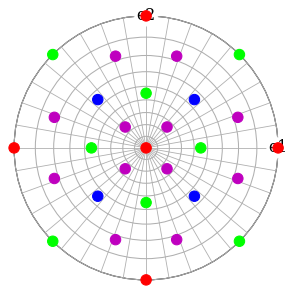

In [48]:
ref.scatter(c=hkl_rgb, grid=True, s=100, axes_labels=["e1", "e2"])

Plot the plane trace of each $(hkl)$ in the stereographic projection

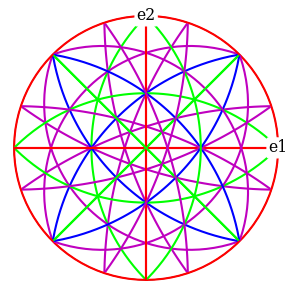

In [49]:
ref.draw_circle(color=hkl_rgb, axes_labels=["e1", "e2"])

Set up geometrical simulations

In [50]:
simulator = kp.simulations.KikuchiPatternSimulator(ref)

Calculate Bragg angles and plot bands in the stereographic projection

In [51]:
simulator.reflectors.calculate_theta(20e3)

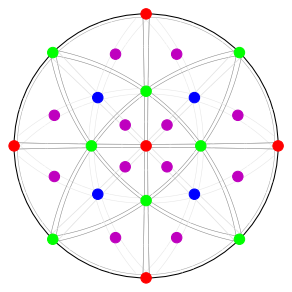

In [52]:
fig = simulator.plot(hemisphere="upper", mode="bands", return_figure=True)
fig.axes[0].scatter(ref, c=hkl_rgb, s=100)

Specify the detector-sample geometry and perform geometrical simulations on the
detector for each orientation found from Hough indexing

In [53]:
detector_cal = kp.detectors.EBSDDetector(
    shape=sig_shape_cal, pc=pc_mean, sample_tilt=70
)
detector_cal

EBSDDetector (480, 480), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.416, 0.226, 0.502)

In [54]:
sim = simulator.on_detector(detector_cal, g)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 102.22 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 102.26 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 103.03 ms


Plot the simulations as markers

In [55]:
sim_markers = sim.as_markers(zone_axes_labels=True)

In [56]:
s_cal.add_marker(sim_markers, permanent=True, plot_signal=False)

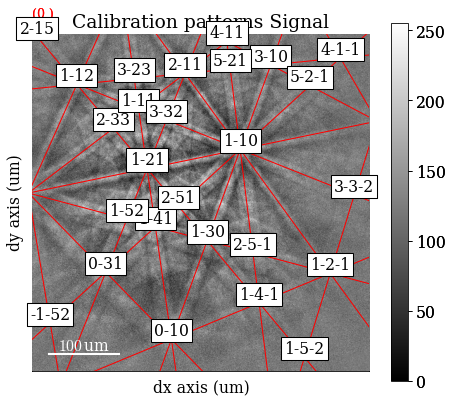

In [57]:
s_cal.plot(navigator="none")

In [58]:
# To delete previously added permanent markers, do
del s_cal.metadata.Markers

## Hough indexing of all patterns

Create a new indexer and Hough index all patterns

In [59]:
sig_shape = s.axes_manager.signal_shape[::-1]
indexer = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="KIKUCHIPY",
    sampleTilt=70,
    camElev=0,
    patDim=sig_shape,
)

Radon Time: 1.0977366429578979
Convolution Time: 5.218197681941092
Peak ID Time: 1.8161073170776945
Band Label Time: 5.154623889975483
Total Band Find Time: 13.287895512999967


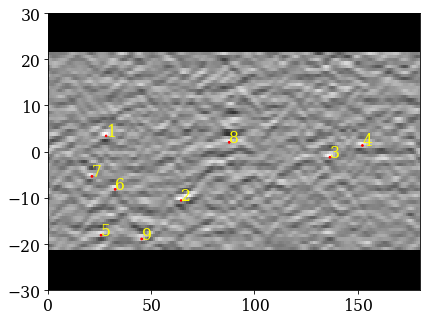

Band Vote Time:  17.0916938240116


In [60]:
hi_res_all = indexer.index_pats(
    s.data.reshape((-1,) + sig_shape), PC=detector_cal.pc, verbose=2
)[0]

Inspect the first output object (the only one kept)

In [61]:
hi_res_all.dtype

dtype([('quat', '<f8', (4,)), ('iq', '<f4'), ('pq', '<f4'), ('cm', '<f4'), ('phase', '<i4'), ('fit', '<f4'), ('nmatch', '<i4'), ('matchattempts', '<i4', (2,)), ('totvotes', '<i4')])

Create map coordinate arrays

In [62]:
step_size = s.axes_manager["x"].scale
nav_shape = s.axes_manager.navigation_shape[::-1]
i, j = np.indices(nav_shape) * step_size

Contain indexing results in a crystal map for easy plotting and saving

In [63]:
xmap_hi = CrystalMap(
    rotations=Orientation(hi_res_all[-1]["quat"]),
    phase_list=PhaseList(phase),
    x=j.ravel(),
    y=i.ravel(),
    prop={
        "pq": hi_res_all[-1]["pq"],
        "cm": hi_res_all[-1]["cm"],
        "fit": hi_res_all[-1]["fit"],
    },
    scan_unit="um",
)

In [64]:
xmap_hi

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: pq, cm, fit
Scan unit: um

Plot pattern quality (PC) and confidence metric (CM) maps

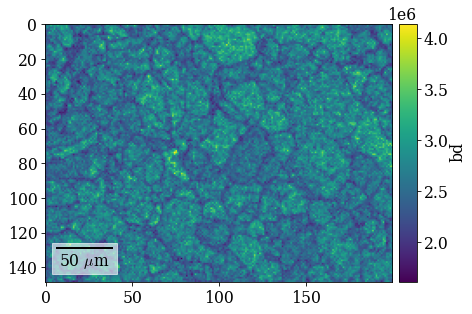

In [65]:
fig = xmap_hi.plot("pq", colorbar=True, colorbar_label="pq", return_figure=True)
fig.savefig(os.path.join(dir_data, "maps_hi_pq.png"))

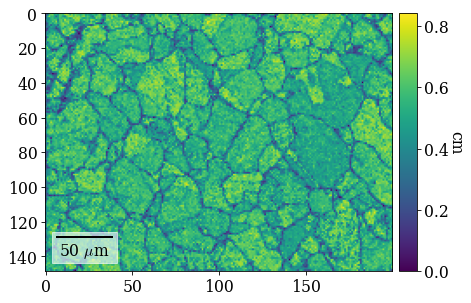

In [66]:
fig = xmap_hi.plot("cm", colorbar=True, colorbar_label="cm", return_figure=True)
fig.savefig(os.path.join(dir_data, "maps_hi_cm.png"))

Plot (IPF-X) orientation map

In [67]:
ipfkey = plot.IPFColorKeyTSL(
    xmap_hi.phases[0].point_group, direction=Vector3d.xvector()
)

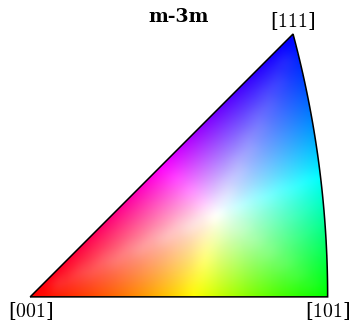

In [68]:
fig = ipfkey.plot(return_figure=True)

In [69]:
# fig.savefig(os.path.join(dir_data, "ipfkey.png"))

In [70]:
ori_hi = xmap_hi.orientations

In [71]:
ori_rgb = ipfkey.orientation2color(ori_hi)

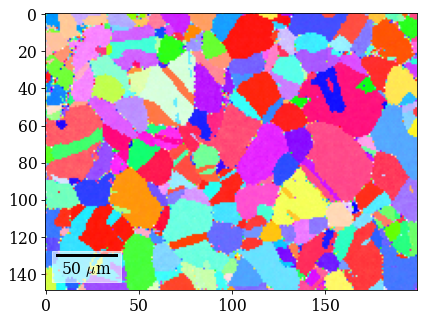

In [72]:
fig = xmap_hi.plot(ori_rgb, return_figure=True)
# fig.savefig(os.path.join(dir_data, "maps_hi_ipfz.png"))

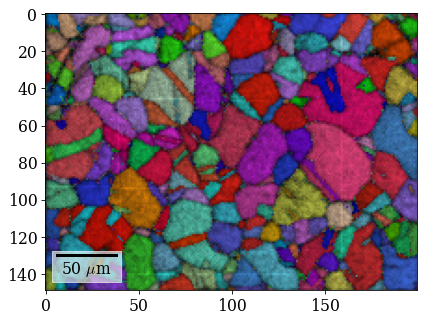

In [73]:
fig = xmap_hi.plot(ori_rgb, overlay=iq.ravel(), return_figure=True)
# fig.savefig(os.path.join(dir_data, "maps_hi_ipfz_iq.png"))

Save Hough indexing results to file (.ang file readable by MTEX, EDAX TSL OIM
Analysis etc., HDF5 file can be read back in into Python)

In [74]:
# io.save(os.path.join(dir_data, "xmap_hi.ang"), xmap_hi)

In [75]:
# io.save(os.path.join(dir_data, "xmap_hi.h5"), xmap_hi)

Create a new detector with a shape corresponding to the experimental patterns

In [76]:
detector = detector_cal.deepcopy()
detector.shape = sig_shape

Get geometrical simulations on this detector for all orientations from the map

In [77]:
ori_hi_2d = ori_hi.reshape(*xmap_hi.shape)
sim_hi = simulator.on_detector(detector, ori_hi_2d)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 102.25 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 203.85 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 303.68 ms


Plot the first simulated pattern

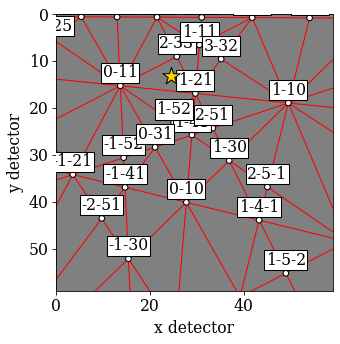

In [78]:
sim_hi.plot()

In [79]:
ori_rgb_2d = ori_rgb.reshape(xmap_hi.shape + (3,))
s_rgb_hi = kp.draw.get_rgb_navigator(ori_rgb_2d)

Add the geometrical simulations

In [80]:
s.add_marker(sim_hi.as_markers(), permanent=True, plot_signal=False)

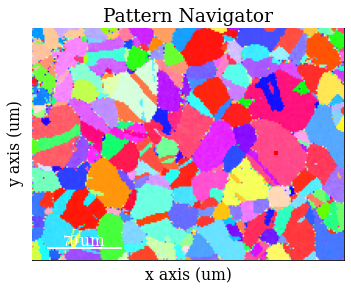

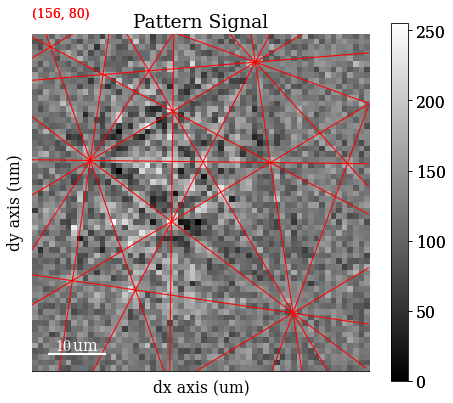

In [81]:
s.plot(s_rgb_hi)

In [82]:
# To delete previously added permanent markers, do
del s.metadata.Markers

## Dictionary indexing

Improve indexing quality by using dynamical simulations. Start by inspecting the
dynamically simulated master pattern in the familiar (?) stereographic projection

In [83]:
mp_sp = kp.data.nickel_ebsd_master_pattern_small(projection="stereographic")

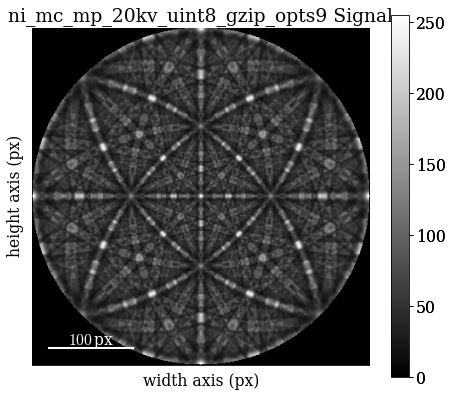

In [84]:
mp_sp.plot()

Plot our geometrical simulation on top of the dynamical simulation

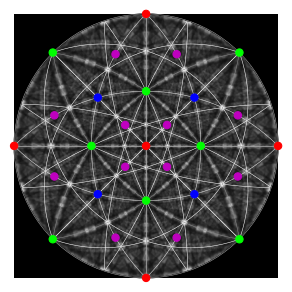

In [85]:
fig = simulator.plot(hemisphere="upper", mode="lines", return_figure=True)
fig.axes[0].scatter(ref, c=hkl_rgb, s=50)

fig.axes[0].imshow(mp_sp.data, cmap="gray", extent=(-1, 1, -1, 1));

Re-load the master pattern but in the Lambert projection, used to generate the
dictionary of dynamically simulated patterns

In [86]:
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert")

Quickly inspect the Lambert master pattern

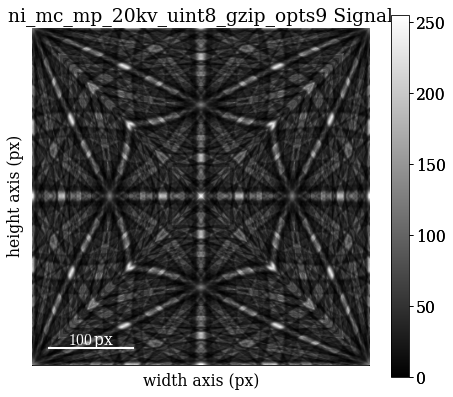

In [87]:
mp.plot()

Discretely sample the complete orientation space of point group $m\bar{3}m$
(*Oh*) with an average misorientation of about 2.4$^{\circ}$ between points

In [88]:
g_sample = sampling.get_sample_fundamental(
    resolution=2.4, point_group=mp.phase.point_group
)
g_sample = Orientation(g_sample, symmetry=mp.phase.point_group)

In [89]:
g_sample

Orientation (58453,) m-3m
[[ 0.8614 -0.3311 -0.3311 -0.1968]
 [ 0.8614 -0.3349 -0.3349 -0.1836]
 [ 0.8614 -0.3384 -0.3384 -0.1703]
 ...
 [ 0.8614  0.3384  0.3384  0.1703]
 [ 0.8614  0.3349  0.3349  0.1836]
 [ 0.8614  0.3311  0.3311  0.1968]]

Plot 1000 sampled orientations in axis-angle space

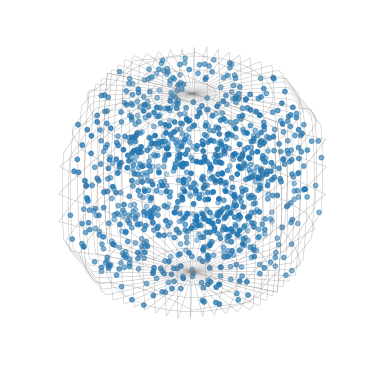

In [90]:
g_sample.get_random_sample(1000).scatter()

Plot all sampled orientations

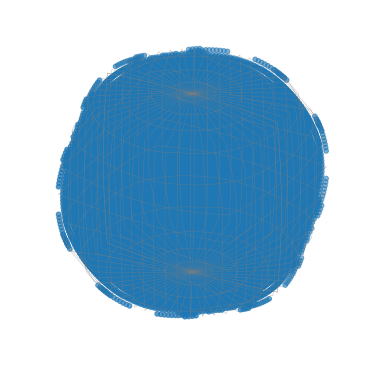

In [91]:
g_sample.scatter()

Plot all sampled orientations in the IPFs X, Y and Z directions

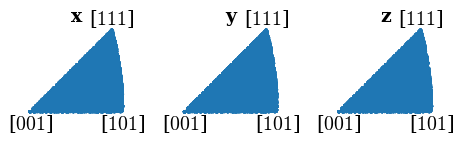

In [92]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
g_sample.scatter("ipf", direction=directions, c="C0", s=5)

Set up generation of the dictionary of dynamically simulated patterns

In [93]:
s_dict = mp.get_patterns(g_sample, detector, energy=20)

Generate the five first patterns and plot them

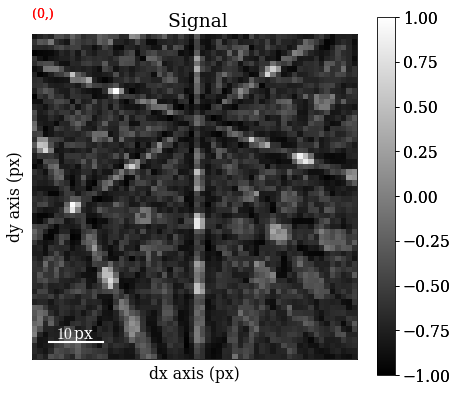

In [94]:
s_dict.inav[:5].plot(navigator="none")

We will use a signal mask so that only pixels with the strongest signal are used during dictionary indexing and refinement

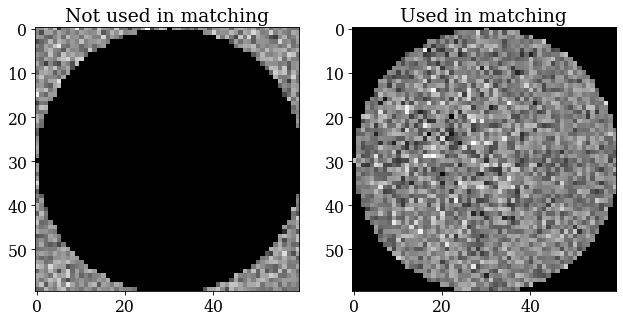

In [95]:
signal_mask = ~kp.filters.Window("circular", detector.shape).astype(bool)

p = s.inav[0, 0].data
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(p * signal_mask, cmap="gray")
ax[0].set_title("Not used in matching")
ax[1].imshow(p * ~signal_mask, cmap="gray")
ax[1].set_title("Used in matching");

Perform dictionary indexing by generating 2000 simulated patterns at a time and
compare them to all the experimental patterns

In [96]:
xmap_di = s.dictionary_indexing(s_dict, signal_mask=signal_mask, n_per_iteration=2000)

Dictionary indexing information:
	Phase name: ni
	Matching 29800 experimental pattern(s) to 58453 dictionary pattern(s)
	NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, signal mask: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.38s/it]


	Indexing speed: 184 patterns/s, 10797920 comparisons/s


In [97]:
xmap_di.scan_unit = "um"

In [98]:
xmap_di

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

In [99]:
xmap_di.scores.shape

(29800, 20)

Plot similarity scores (normalized cross-correlation, NCC) between best matching
experimental and simulated patterns

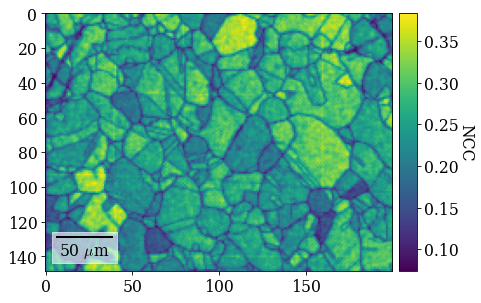

In [100]:
fig = xmap_di.plot(
    xmap_di.scores[:, 0], colorbar=True, colorbar_label="NCC", return_figure=True
)
# fig.savefig(os.path.join(dir_data, "maps_di_ncc.png"))

Plot IPF-X orientation map

In [101]:
g_rgb_di = ipfkey.orientation2color(xmap_di.orientations)

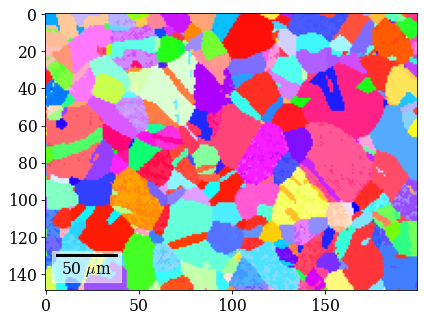

In [102]:
fig = xmap_di.plot(g_rgb_di, return_figure=True)
# fig.savefig(os.path.join(dir_data, "maps_di_ipfz.png"))

Save dictionary indexing results to file

In [103]:
# io.save(os.path.join(dir_data, "xmap_di.ang"), xmap_di)
# io.save(os.path.join(dir_data, "xmap_di.h5"), xmap_di)

## Orientation refinement

Refine dictionary indexing results by re-generating dynamically simulated patterns iteratively by letting the discretly sampled orientations vary within +/- 1.5$^{\circ}$ and finding the best match

In [104]:
xmap_ref = s.refine_orientation(
    xmap=xmap_di,
    detector=detector,
    master_pattern=mp,
    energy=20,
    mask=signal_mask,
    method_kwargs=dict(options=dict(fatol=0.001)),
)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'options': {'fatol': 0.001}, 'method': 'Nelder-Mead'}
Refining 29800 orientation(s):
[########################################] | 100% Completed | 290.56 s
Refinement speed: 102 patterns/s


In [105]:
xmap_ref

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores
Scan unit: um

Plot refined NCC scores

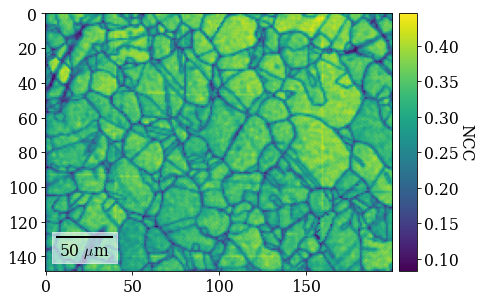

In [106]:
fig = xmap_ref.plot(
    xmap_ref.scores, colorbar=True, colorbar_label="NCC", return_figure=True
)
# fig.savefig(os.path.join(dir_data, "maps_di_ref_ncc.png"))

Plot refined IPF-X orientation map

In [107]:
g_rgb_ref = ipfkey.orientation2color(xmap_ref.orientations)

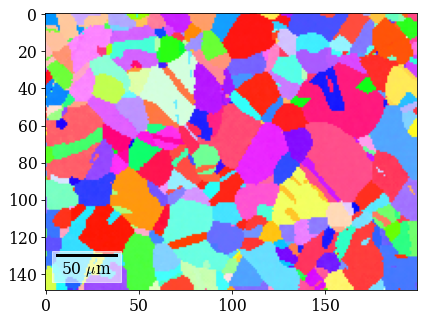

In [108]:
fig = xmap_ref.plot(g_rgb_ref, return_figure=True)
# fig.savefig(os.path.join(dir_data, "maps_di_ref_ipfz.png"))

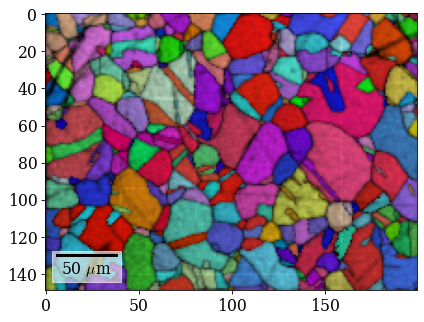

In [109]:
fig = xmap_ref.plot(g_rgb_ref, return_figure=True, overlay=xmap_ref.scores)
# fig.savefig(os.path.join(dir_data, "maps_di_ref_ipfz_ncc.png"))

Save refined results to file

In [110]:
# io.save(os.path.join(dir_data, "xmap_di_ref.ang"), xmap_ref)
# io.save(os.path.join(dir_data, "xmap_di_ref.h5"), xmap_ref)